In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from concurrent.futures import ThreadPoolExecutor
import category_encoders as ce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import xgboost as xgb
import category_encoders as ce

In [3]:
def extract_features(file_path):
    """
    Extracts audio features from a given file using Librosa.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    try:
        y, sr = librosa.load(file_path, sr=22050)

        n_fft = 2048
        hop_length = 512

        duration = len(y) / sr

        # Compute STFT once and reuse
        stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        stft_abs = np.abs(stft)

        # Fundamental frequency using YIN (faster than PYIN)
        f0 = librosa.yin(y, fmin=80, fmax=400, sr=sr,
                          frame_length=n_fft, hop_length=hop_length)

        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=stft_abs, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(S=stft_abs, sr=sr)

        mfccs = librosa.feature.mfcc(
            S=librosa.power_to_db(stft_abs**2),
            n_mfcc=13,
            sr=sr,
            lifter=22  # Cepstral liftering for robustness
        )

        delta1 = librosa.feature.delta(mfccs)
        delta2 = librosa.feature.delta(mfccs, order=2)

        features = {
            'duration': duration,
            'f0_mean': np.nanmean(f0),
            'f0_std': np.nanstd(f0),
            'spectral_bandwidth_mean': np.mean(spectral_bandwidth),
            'spectral_bandwidth_std': np.std(spectral_bandwidth),
            'spectral_contrast': np.mean(librosa.feature.spectral_contrast(S=stft_abs, sr=sr)),
            'spectral_rolloff_mean': np.mean(spectral_rolloff),
            'spectral_rolloff_std': np.std(spectral_rolloff), 
            'harmonic_mean': np.mean(librosa.effects.hpss(y)[0]),
            'percussive_mean': np.mean(librosa.effects.hpss(y)[1]),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=y)),
        }

        # MFCC statistics for selected coefficients (0-based indices)
        for coeff in range(13):
            for feature_set, data in [('', mfccs),
                                      ('_delta1', delta1),
                                      ('_delta2', delta2)]:
                coeff_data = data[coeff]
                features.update({
                    f'mfcc_{coeff+1}{feature_set}_mean': np.mean(coeff_data),
                    f'mfcc_{coeff+1}{feature_set}_std': np.std(coeff_data),
                    f'mfcc_{coeff+1}{feature_set}_skew': scipy.stats.skew(coeff_data),
                })

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [4]:
def process_audio_file(audio_path, base_dir):
    """Helper function to extract features for a single file."""
    file_path = os.path.join(base_dir, audio_path)
    return extract_features(file_path)

In [5]:
def load_and_process_data(base_dir, csv_filename, num_threads=4):
    """
    Loads a CSV, extracts features using multithreading, and updates the DataFrame.
    """
    df = pd.read_csv(os.path.join(base_dir, csv_filename))
    audio_paths = df['path'].tolist()
    all_new_features = []

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(process_audio_file, audio_path, base_dir) for audio_path in audio_paths]
        for future in tqdm(futures, total=len(audio_paths), desc=f"Processing {csv_filename}"):
            features = future.result()
            all_new_features.append(features if features else {})

    # Create a DataFrame from the list of new features and concatenate it
    new_features_df = pd.DataFrame(all_new_features)
    df = pd.concat([df, new_features_df], axis=1)

    return df

In [ ]:
base_dir = "DSL_Winter_Project_Data"
df_train = load_and_process_data(base_dir, "development.csv")
df_test = load_and_process_data(base_dir, "evaluation.csv")

Processing development.csv:   1%|▏         | 43/2933 [00:13<15:09,  3.18it/s] 


# EDA

In [1]:

def data_pipeline(df):
    
    df = df.drop(columns=["sampling_rate", "path", "Id"], errors='ignore')
    df["tempo"] = pd.to_numeric(df["tempo"].astype(str).str.strip("[]"), errors='coerce')
    
    # Save original gender values for debugging
    df['gender_original'] = df['gender'].copy()
    
    # Clean and map the 'gender' column
    if 'gender' in df.columns:
        df['gender'] = (
            df['gender']
            .astype(str)
            .str.strip()  # Remove leading/trailing spaces
            .str.lower()  # Convert to lowercase
            .replace({'male': 'male', 'female': 'female'})  # Handle variants
        )
        df['gender'] = df['gender'].map({"male": 0, "female": 1})
        
        # Identify rows with NaN in 'gender' (i.e., erroneous values)
        erroneous_gender_rows = df[df['gender'].isnull()]
        if not erroneous_gender_rows.empty:
            print("Rows with erroneous gender values:")
            print(erroneous_gender_rows[['gender_original']])
        
        # Fill NaN with mode (if any)
        gender_mode = df['gender'].mode()[0]
        df['gender'] = df['gender'].fillna(gender_mode)
    
    # Drop the temporary 'gender_original' column
    df = df.drop(columns=['gender_original'], errors='ignore')
    
    if 'age' in df.columns:
        df["age"] = df["age"].round()

    
    # 1. Handle extreme pitch values
    df['pitch_range'] = df['max_pitch'] - df['min_pitch']
    
    pitch_outliers = (
        (df['mean_pitch'] > 3000) |  # Unrealistic mean pitch
        (df['min_pitch'] < 50) |     # Unrealistic minimum pitch
        (df['max_pitch'] > 4000)      # Unrealistic maximum pitch
    )
    df.loc[pitch_outliers, 'pitch_range'] = np.nan

    # 2. Handle duration-based anomalies
    if 'silence_duration' in df.columns:
        # Flag suspicious silence durations
        df['silence_ratio'] = df['silence_duration'] / df['duration']
        df.loc[df['silence_ratio'] > 0.8, 'silence_duration'] = np.nan
    
    # 3. Handle ethnicity-specific patterns
    if 'ethnicity' in df.columns:
        # Create flag for igbo speakers (they have different patterns in your data)
        df['is_igbo'] = (df['ethnicity'] == 'igbo').astype(int)
        
        # Separate handling for igbo speakers who often have shorter recordings
        df['words_per_duration'] = df['num_words'] / df['duration']
        df['is_valid_speech'] = (
            (df['is_igbo'] == 0) & (df['words_per_duration'] < df['words_per_duration'].quantile(0.95)) |
            (df['is_igbo'] == 1) & (df['words_per_duration'] < df['words_per_duration'].quantile(0.99))
        )
        
    # 4. Handle acoustic feature outliers
    acoustic_features = ['jitter', 'shimmer', 'hnr', 'energy']
    for feature in acoustic_features:
        if feature in df.columns:
            q1 = df[feature].quantile(0.25)
            q3 = df[feature].quantile(0.75)
            iqr = q3 - q1
            df.loc[
                (df[feature] < q1 - 3*iqr) | (df[feature] > q3 + 3*iqr), 
                feature
            ] = np.nan 
       
    # 5. Create age groups for potential interaction terms
    if 'age' in df.columns:
            df['age_group'] = pd.cut(df['age'], bins=[0, 16, 20, 25, 30, 35, 45, 55, 70 , 100], labels=['0-16', '16-20', '20-25', '25-30', '30-35', '35-45', '45-55', '55-70', '70+'])

    
    
    if 'num_words' in df.columns and 'num_characters' in df.columns and 'silence_duration' in df.columns:
    # Create flags for zero words/characters and long clips
        df['is_zero_words'] = ((df['num_words'] == 0) & (df['num_characters'] == 0)).astype(int)
        df['is_short_clip'] = ((df['num_words'] <= 15) & (df['num_words'] >= 1)).astype(int)
        df['is_med_clip'] = ((df['num_words'] > 15) & (df['num_words'] < 60)).astype(int)
        df['is_long_clip'] = (df['num_words'] >= 60).astype(int)
        # Replace 0 in 'num_words' with 1 to avoid division by zero
        df['num_words_modified'] = df['num_words'].replace(0, 1)  # Create a modified column
        df['silence_duration_ratio'] = df['silence_duration'] / df['num_words_modified']
        df['avg_pause_duration'] = df['silence_duration'] / (df['num_pauses'] + 1e-7)
        df['avg_pause_per_record'] = df['num_pauses'] / df['duration']

        
        # Interaction features with 'is_long_clip'
        if 'is_long_clip' in df.columns:
            
            df['silence_duration_ratio_long'] = df['silence_duration_ratio'] * df['is_long_clip']
            df['duration_x_is_long_clip'] = df['duration'] * df['is_long_clip']
            df['avg_pause_per_record_x_is_long_clip'] = df['avg_pause_per_record'] * df['is_long_clip']
            df['avg_pause_duration_x_is_long_clip'] = df['avg_pause_duration'] * df['is_long_clip']
            df['silence_duration_x_is_long_clip'] = df['silence_duration'] * df['is_long_clip']

        # Interaction features with 'is_zero_words'
        if 'is_zero_words' in df.columns:
            df['silence_duration_ratio_is_zero_words'] = df['silence_duration_ratio'] * df['is_zero_words']
            df['avg_pause_per_record_x_is_zero_words'] = df['avg_pause_per_record'] * df['is_zero_words']
            df['avg_pause_duration_x_is_zero_words'] = df['avg_pause_duration'] * df['is_zero_words']
            df['duration_x_is_zero_words'] = df['duration'] * df['is_zero_words']
            df['silence_duration_x_is_zero_words'] = df['silence_duration'] * df['is_zero_words']
        

        if 'is_short_clip' in df.columns:
            df['silence_duration_is_short_clip'] = df['silence_duration'] * df['is_short_clip']
            df['avg_pause_per_record_x_is_short_clip'] = df['avg_pause_per_record'] * df['is_short_clip']
            df['avg_pause_duration_x_is_short_clip'] = df['avg_pause_duration'] * df['is_short_clip']
            df['duration_x_is_short_clip'] = df['duration'] * df['is_short_clip']
            df['silence_duration_x_is_short_clip'] = df['silence_duration'] * df['is_short_clip']
        
        if 'is_med_clip' in df.columns:
            df['silence_duration_is_med_clip'] = df['silence_duration'] * df['is_med_clip']
            df['avg_pause_per_record_x_is_med_clip'] = df['avg_pause_per_record'] * df['is_med_clip']
            df['avg_pause_duration_x_is_med_clip'] = df['avg_pause_duration'] * df['is_med_clip']
            df['duration_x_is_med_clip'] = df['duration'] * df['is_med_clip']
            df['silence_duration_x_is_med_clip'] = df['silence_duration'] * df['is_med_clip']
        
    return df

In [9]:
# Preprocess training and test data
df_train_pre = data_pipeline(df_train)
df_test_pre = data_pipeline(df_test)


Rows with erroneous gender values:
    gender_original
454          famale


In [54]:
print(df_train_pre[df_train_pre['silence_duration_ratio'] != 1][['duration', 'num_words', 'silence_duration','num_pauses']])

       duration  num_words  silence_duration  num_pauses
0     35.095238         69         23.846893          39
1     23.331293         69         19.388662          21
2     21.667891         69         21.640998           1
3     22.476961         69         19.644127           9
4     19.090295         69         18.041905          11
...         ...        ...               ...         ...
2928  20.410748         69         17.461406          11
2929   1.509206          0          1.509206           1
2930   1.645034          1          1.645034           1
2931  20.708163         69         16.346848          19
2932   2.394104          0          2.275556           4

[2933 rows x 4 columns]


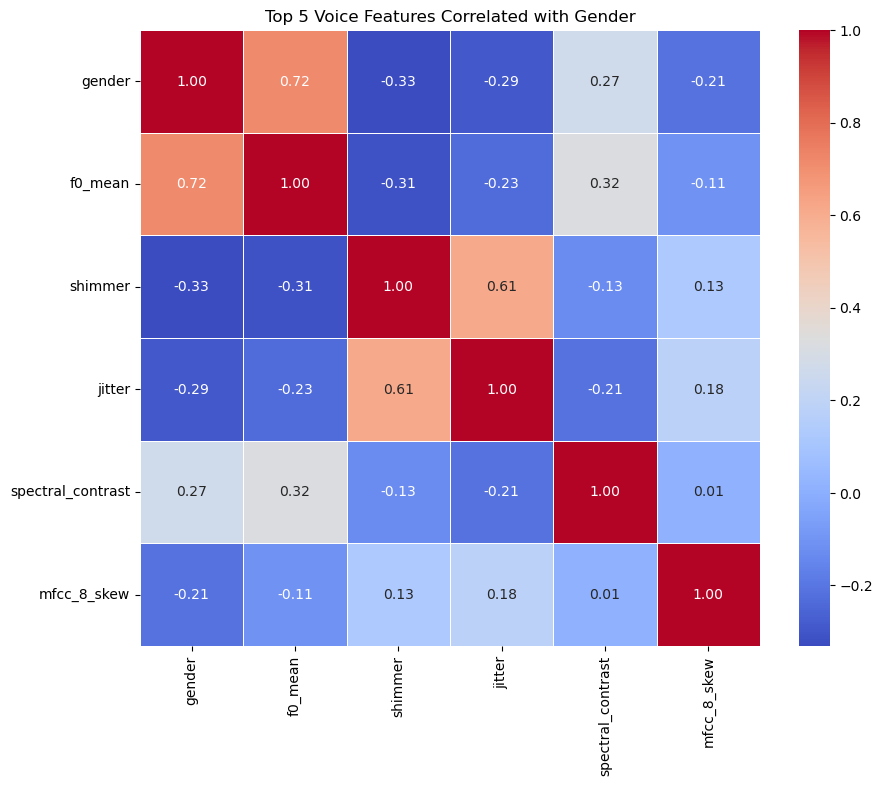

In [10]:
numerical_columns = df_train_pre.select_dtypes(include=['int64', 'float64']).columns

correlations = df_train_pre[numerical_columns].corr()['gender'].abs().sort_values(ascending=False)

# Step 3: Select the top 5 features most correlated with gender
top_10_features = correlations[0:6].index  

# Step 4: Create a correlation matrix for the top 10 features
correlation_matrix = df_train_pre[top_10_features].corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Top 5 Voice Features Correlated with Gender')
plt.show()

In [2]:
def group_ethnicity(df, df_name, threshold=0.96):
    # 1. First handle special cases for Igbo
    igbo_mask = df['ethnicity'] == 'igbo'
    short_recording_mask = df['num_words'] <= 5  # Very short recordings
    suspicious_igbo = igbo_mask & short_recording_mask
    
    # Remove suspicious Igbo recordings with very short duration
    if df_name == 'df_train_pre':
        df = df[~suspicious_igbo]
    
    # 2. Group ethnicities based on frequency
    ethnicity_counts = df['ethnicity'].value_counts()
    total_samples = len(df)
    
    # Get major ethnic groups (covering threshold% of data)
    cumulative_percentage = ethnicity_counts.cumsum() / total_samples
    frequent_ethnicities = cumulative_percentage[cumulative_percentage <= threshold].index.tolist()
    
    # 3. Create regional groups for less frequent ethnicities
    df['ethnicity_grouped'] = df['ethnicity'].apply(
        lambda x: x if x in frequent_ethnicities 
        else 'african' if x in ['yoruba', 'hausa', 'urhobo', 'edo', 'efik', 'ibibio', 'tiv', 'obudu', 'afemai']
        else 'asian' if x in ['mandarin', 'korean', 'japanese', 'vietnamese', 'thai', 'hindi', 'gujarati', 'bengali']
        else 'european' if x in ['german', 'french', 'italian', 'spanish', 'portuguese', 'dutch', 'polish', 'russian']
        else 'Other'
    )
    
    df = df.drop(columns=['ethnicity'])
    return df

In [12]:
def feature_engineering(df, top_features=None):
    df = df.drop(columns=['num_words', 'num_characters', 'duration', 'silence_duration'])
    if 'gender' in df.columns:
        if top_features is None:
            # Calculate top features only if not provided (for training data)
            numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
            correlations = df[numerical_columns].corr()['gender'].abs().sort_values(ascending=False)
            top_features = correlations[1:11].index.tolist()  # Save as list
        # Create interaction terms using the provided/calculated top_features
        for feature in top_features:
            if feature in df.columns:
                df[f'{feature}_x_gender'] = df[feature] * df['gender']
    return df, top_features  # Return both the DF and top_features

In [13]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.ensemble import RandomForestRegressor


# Group ethnicity
df_train_grouped = group_ethnicity(df_train_pre, df_name='df_train_pre')
df_test_grouped = group_ethnicity(df_test_pre, df_name='df_test_pre')

# Feature engineering
df_train_final, top_features = feature_engineering(df_train_grouped)  # Save top_features
df_test_final, _ = feature_engineering(df_test_grouped, top_features=top_features)  # Reuse top_features


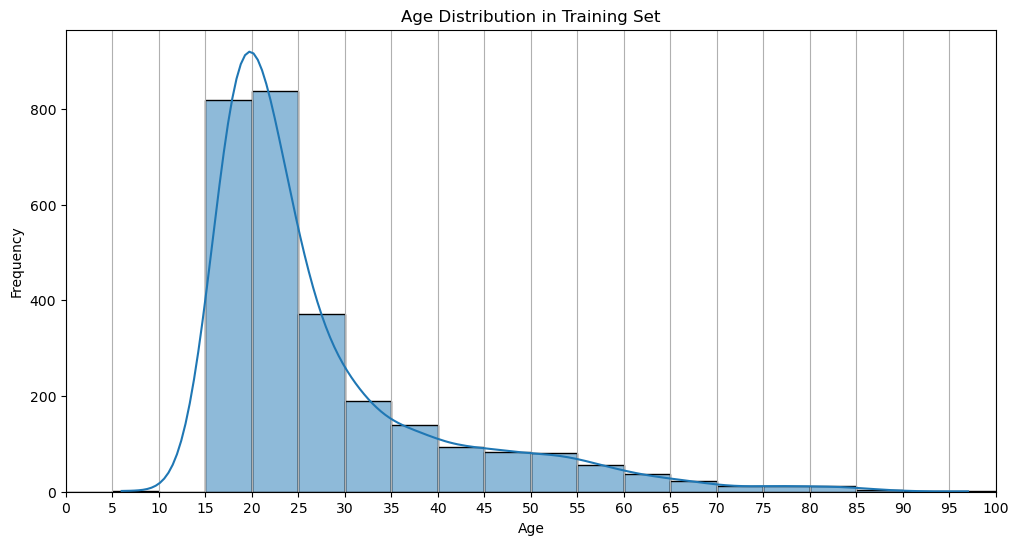

In [39]:
def plot_age_distribution(df, title="Age Distribution", bin_width=5, max_age=100):
    """
    Plots the age distribution with more detailed age labels on the x-axis.

    Args:
        df (pd.DataFrame): The DataFrame containing an 'age' column.
        title (str): The title of the plot.
        bin_width (int): The width of each bin in the histogram.
        max_age (int): The maximum age to display on the x-axis.
    """
    plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

    # Create bins based on the specified bin width and maximum age
    bins = np.arange(0, max_age + bin_width, bin_width)

    sns.histplot(df['age'], bins=bins, kde=True)
    plt.title(title)
    plt.xlabel("Age")
    plt.ylabel("Frequency")

    # Set detailed x-axis ticks and labels
    plt.xticks(np.arange(0, max_age + 1, 5))  # Set ticks every 5 years

    plt.xlim(0, max_age)  # Set x-axis limits

    plt.grid(axis='x')  # Add grid lines for better readability of x-axis values
    plt.show()

# Example usage:
plot_age_distribution(df_train_final, title="Age Distribution in Training Set", bin_width=5, max_age=100)

In [3]:
def create_age_weights(df):
    """
    Creates age group weights based on sample distribution and domain knowledge.
    Returns both age groups dictionary and a function to get weights.
    """
    # Calculate age distribution
    age_counts = df['age'].value_counts(bins=10).sort_index()
    total_samples = len(df)
    
    # Create inverse-frequency weights with smoothing
    age_groups = {
        (0, 15): 3.5,    # Teens (underrepresented, crucial for voice changes)
        (15, 25): 1.0,   # Young adults (most common group, baseline weight)
        (25, 35): 1.3,   # Adults (moderately represented)
        (35, 50): 2,   # Middle-aged (less represented)
        (50, 65): 4.0,   # Senior adults (underrepresented)
        (65, 100): 6.0   # Elderly (very underrepresented)
    }
    
    def get_age_weight(age):
        """Get weight for a specific age."""
        for (lower, upper), weight in age_groups.items():
            if lower <= age < upper:
                return weight
        return 1.0  # Default weight
    
    return age_groups, get_age_weight

In [15]:
X = df_train_final.drop(columns=["age"])  # Drop 'age_group' as it's not a feature
y = df_train_final["age"]
X_test = df_test_final.drop(columns=["age"], errors='ignore')

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
age_groups, get_age_weight = create_age_weights(df_train_final)  # Create using full training data
X_train.loc[:, 'sample_weight'] = y_train.apply(get_age_weight)
X_val.loc[:, 'sample_weight'] = y_val.apply(get_age_weight)

sample_weights_train = X_train["sample_weight"].values
sample_weights_val = X_val["sample_weight"].values

X_train = X_train.drop(columns=["sample_weight"])
X_val = X_val.drop(columns=["sample_weight"])

NameError: name 'df_train_final' is not defined

In [19]:
from sklearn.impute import SimpleImputer

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    ('power_transform', PowerTransformer()),
    ('variance_filter', VarianceThreshold(threshold=0.01)),
    ('model_based_selection', SelectFromModel(estimator=RandomForestRegressor(random_state=42), threshold='median')),
])

categorical_transformer = Pipeline(steps=[
    ('encoder', ce.CatBoostEncoder(handle_unknown='ignore')) # Use handle_unknown to avoid errors with new categories in validation set
])

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
],remainder='passthrough')

In [ ]:
def validate_transformations(X_train, X_val, preprocessor):
    """Validate that transformations work on both training and validation data"""
    try:
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_val_transformed = preprocessor.transform(X_val)
        print("Transformations successful!")
        print(f"Training shape: {X_train_transformed.shape}")
        print(f"Validation shape: {X_val_transformed.shape}")
        return True
    except Exception as e:
        print(f"Transformation error: {str(e)}")
        return False

# Use the validation
validate_transformations(X_train, X_val, preprocessor)

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet

In [21]:
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'preprocessor__num__scaler': [RobustScaler()],
    'preprocessor__num__power_transform': [PowerTransformer()],
    'preprocessor__num__model_based_selection__threshold': ['mean', 'median'],
    'model__n_estimators': [600],
    'model__max_depth': [20],
    'model__min_samples_split': [2],
    'model__min_samples_leaf': [10]
}

grid_search = GridSearchCV(
    full_pipeline,
    param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train, model__sample_weight=sample_weights_train)

best_model = grid_search.best_estimator_

# --- Make predictions ---
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)

# --- Evaluate the model ---
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("Best Params:", grid_search.best_params_)
print("Best CV Score (RMSE):", -grid_search.best_score_)
print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)

# --- Calculate residuals ---
residuals = y_train - y_pred_train

# --- Convert results to DataFrame ---
results = pd.DataFrame(grid_search.cv_results_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END model__max_depth=20, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=600, preprocessor__num__model_based_selection__threshold=mean, preprocessor__num__power_transform=PowerTransformer(), preprocessor__num__scaler=RobustScaler(); total time=  26.4s
[CV] END model__max_depth=20, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=600, preprocessor__num__model_based_selection__threshold=mean, preprocessor__num__power_transform=PowerTransformer(), preprocessor__num__scaler=RobustScaler(); total time=  26.5s
[CV] END model__max_depth=20, model__min_samples_leaf=10, model__min_samples_split=2, model__n_estimators=600, preprocessor__num__model_based_selection__threshold=mean, preprocessor__num__power_transform=PowerTransformer(), preprocessor__num__scaler=RobustScaler(); total time=  27.2s
[CV] END model__max_depth=20, model__min_samples_leaf=10, model__min_samples_split=2,

In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf

# Dictionary to store model performances
model_performances = {}

# 1. XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

xgb_params = {
    'model__n_estimators': [500, 1000],
    'model__max_depth': [5, 7, 9],
    'model__learning_rate': [0.01, 0.05],
    'model__min_child_weight': [1, 3],
    'model__subsample': [0.8, 0.9],
    'model__colsample_bytree': [0.8, 0.9]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, xgb_params, 
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1, verbose=2
)
xgb_grid.fit(X_train, y_train, model__sample_weight=sample_weights_train)

# 2. CatBoost
cat_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(random_state=42, verbose=False))
])

cat_params = {
    'model__iterations': [500, 1000],
    'model__depth': [6, 8, 10],
    'model__learning_rate': [0.01, 0.05],
    'model__l2_leaf_reg': [3, 5]
}

cat_grid = GridSearchCV(
    cat_pipeline, cat_params,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1, verbose=2
)
cat_grid.fit(X_train, y_train, model__sample_weight=sample_weights_train)

# 3. LightGBM
lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

lgb_params = {
    'model__n_estimators': [500, 1000],
    'model__max_depth': [5, 7, 9],
    'model__learning_rate': [0.01, 0.05],
    'model__num_leaves': [31, 63],
    'model__subsample': [0.8, 0.9]
}

lgb_grid = GridSearchCV(
    lgb_pipeline, lgb_params,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1, verbose=2
)
lgb_grid.fit(X_train, y_train, model__sample_weight=sample_weights_train)

# 4. Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=42))
])

ridge_params = {
    'model__alpha': [0.1, 1.0, 10.0],
    'model__solver': ['auto', 'svd']
}

ridge_grid = GridSearchCV(
    ridge_pipeline, ridge_params,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1, verbose=2
)
ridge_grid.fit(X_train, y_train)  # Ridge doesn't support sample weights

# 5. Neural Network (Keras)
def create_nn_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# First transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Create and train NN
nn_model = create_nn_model(X_train_transformed.shape[1])
history = nn_model.fit(
    X_train_transformed, y_train,
    validation_data=(X_val_transformed, y_val),
    sample_weight=sample_weights_train,
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=5)
    ],
    verbose=1
)

# Evaluate all models
def evaluate_model(model, name):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    val_r2 = r2_score(y_val, y_pred_val)
    
    return {
        'name': name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'val_r2': val_r2
    }

# Store results
models = {
    'XGBoost': xgb_grid.best_estimator_,
    'CatBoost': cat_grid.best_estimator_,
    'LightGBM': lgb_grid.best_estimator_,
    'Ridge': ridge_grid.best_estimator_
}

results = []
for name, model in models.items():
    results.append(evaluate_model(model, name))

# Add NN results
nn_train_pred = nn_model.predict(X_train_transformed)
nn_val_pred = nn_model.predict(X_val_transformed)
results.append({
    'name': 'Neural Network',
    'train_rmse': np.sqrt(mean_squared_error(y_train, nn_train_pred)),
    'val_rmse': np.sqrt(mean_squared_error(y_val, nn_val_pred)),
    'val_r2': r2_score(y_val, nn_val_pred)
})

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot results
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['train_rmse'], width, label='Train RMSE')
plt.bar(x + width/2, results_df['val_rmse'], width, label='Validation RMSE')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['name'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Step 8: Test Set Predictions (Using the best performing model)
final_predictions = np.round(best_model.predict(X_test)).astype(int)  # Replace with the desired best model

# Save Predictions
test_results = pd.DataFrame({"Id": X_test.index, "Predicted": final_predictions})
test_results.to_csv("test_predictions.csv", index=False)

print("Pipeline completed and predictions saved!")
print(test_results.shape)


Pipeline completed and predictions saved!
(691, 2)


In [180]:
# Check for NaN values in X_test
nan_columns = X_test.columns[X_test.isnull().any()].tolist()
nan_counts = X_test[nan_columns].isnull().sum()

print("Columns with NaN values in X_test:")
print(nan_counts)

Columns with NaN values in X_test:
Series([], dtype: float64)


In [172]:
print("Missing values in gender column:", df_test['gender'].isnull().sum())
print("Missing values in  gender column:", df_test_pre['gender'].isnull().sum())
print("Missing values in gender column:", df_test_grouped['gender'].isnull().sum())
print("Missing values in gender column:", df_test_final['gender'].isnull().sum())

Missing values in gender column: 0
Missing values in  gender column: 0
Missing values in gender column: 0
Missing values in gender column: 0


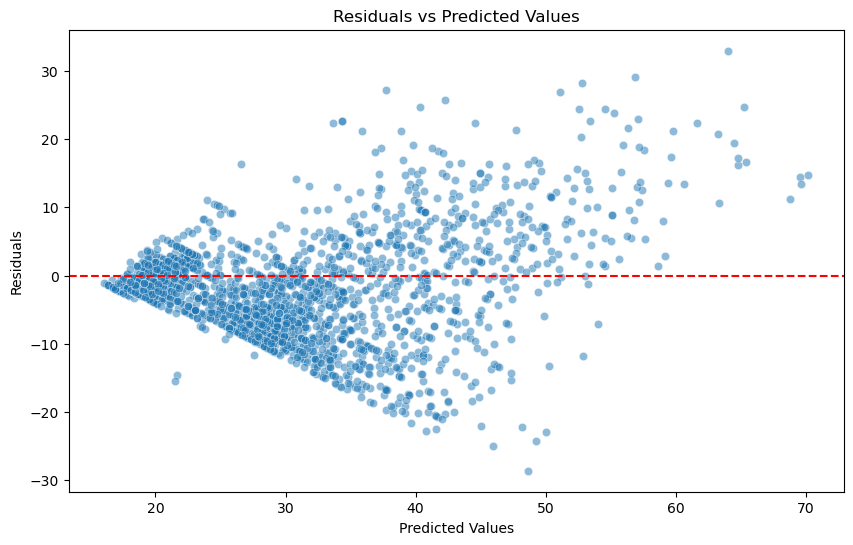

In [23]:
# Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_train, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

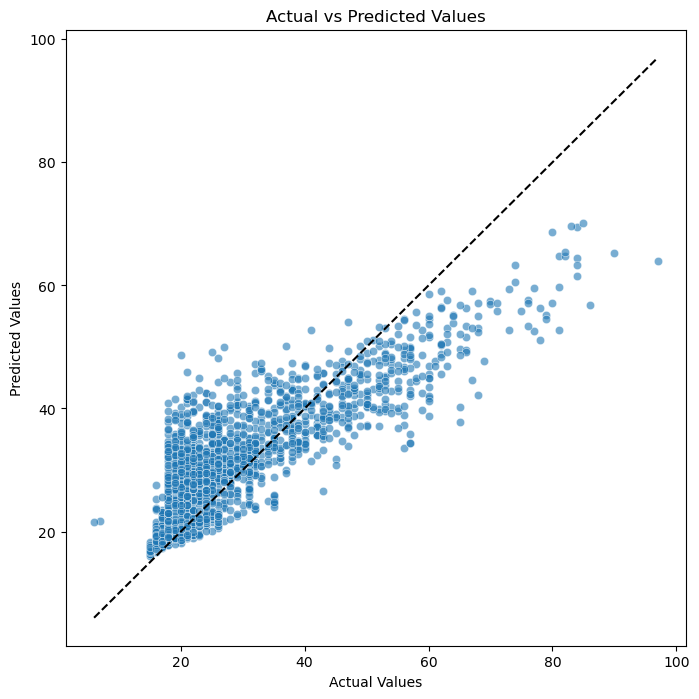

In [24]:
# Actual vs Predicted Values
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_train, y=y_pred_train, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], 
         [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

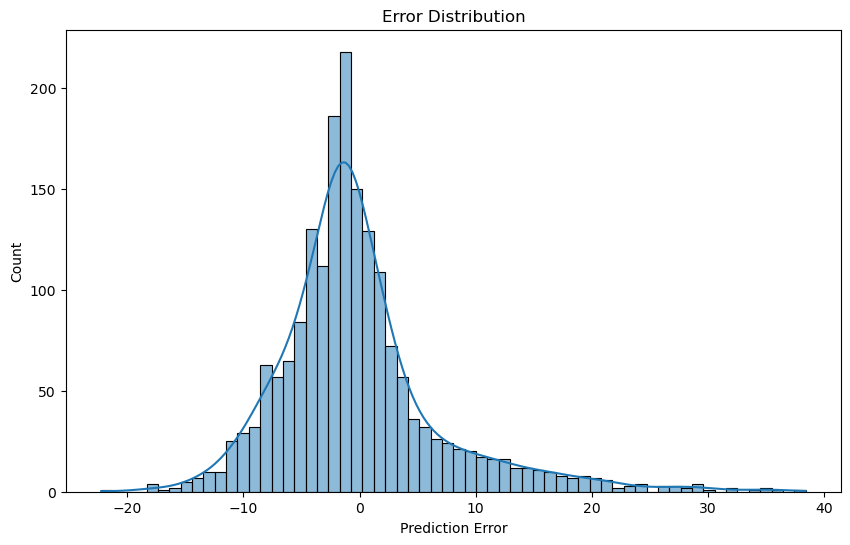

In [250]:
# Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Prediction Error")
plt.title("Error Distribution")
plt.show()


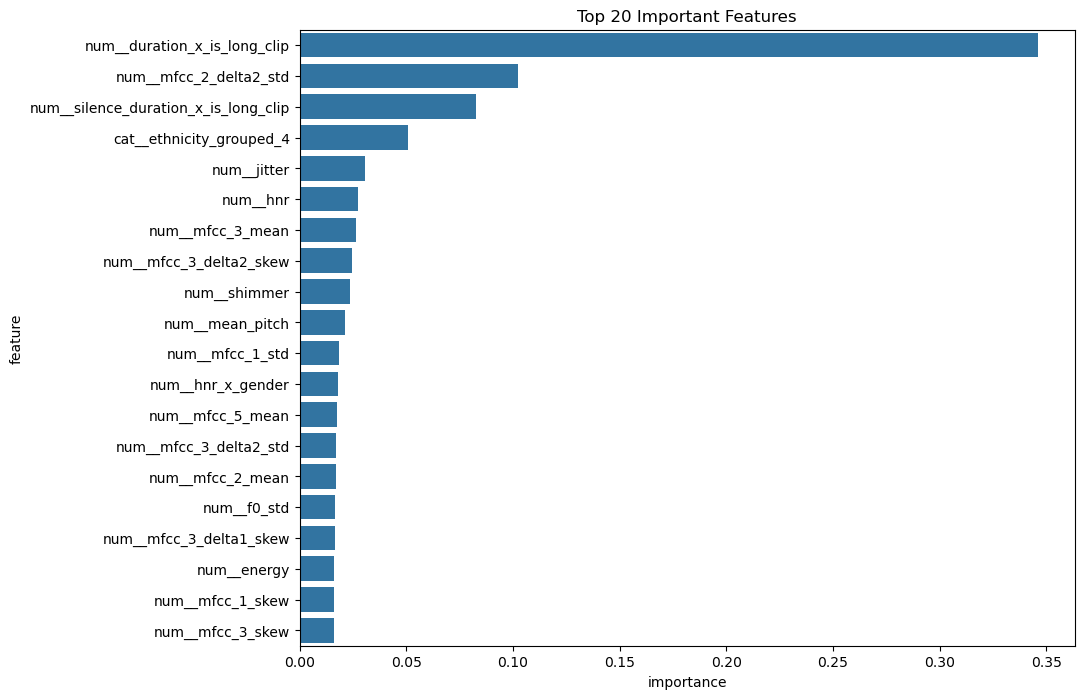

In [151]:
# Feature Importance
# Get feature names after preprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the best model
importances = best_model.named_steps['model'].feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title("Top 20 Important Features")
plt.show()



# Test 1 (with full numerical transformation)
Random Forest Best Params: {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest Best CV Score (RMSE): 10.723203987455909
Random Forest Validation RMSE: 9.748362557975705
# Test 2 - no imputer
Random Forest Best CV Score (RMSE): 10.723203987455909
Random Forest Validation RMSE: 9.748362557975705
# Test 3 - no scaler
Random Forest Best CV Score (RMSE): 10.694221839871847
Random Forest Validation RMSE: 9.72994245801065
# Test 4 - robust scaler
Random Forest Best CV Score (RMSE): 10.723443379463992
Random Forest Validation RMSE: 9.748462364116902

Random Forest Best Params: {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.71862526780365
Random Forest Validation RMSE: 9.74660991239993


# Ethnicity threshold dropped to %97 --> %93
Random Forest Best Params: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.744418675374899
Random Forest Validation RMSE: 9.786175623940476

Random Forest Best Params: {'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.744368015969183
Random Forest Validation RMSE: 9.786703251752213

# Ethnicity threshold raised to %98
Random Forest Best Params: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.719811495003354
Random Forest Validation RMSE: 9.761445445390352

# %96
Random Forest Best Params: {'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.699615172335374
Random Forest Validation RMSE: 9.746993997688008

# num_words binned and categorised

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Random Forest Best Params: {'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 600}
Random Forest Best CV Score (RMSE): 10.691356186194717
Random Forest Validation RMSE: 9.695453960994419


# gender interaction terms limited to |5 most correlated| voice features 
Random Forest Best CV Score (RMSE): 10.71383296593041
Random Forest Validation RMSE: 9.683654777972615


# used all gender interaction terms
Random Forest Best CV Score (RMSE): 10.719220177067221
Random Forest Validation RMSE: 9.674992066781806

Random Forest Best CV Score (RMSE): 10.719694608451054
Random Forest Validation RMSE: 9.692188076875114

Random Forest Best CV Score (RMSE): 10.707280929204535
Random Forest Validation RMSE: 9.67862959713767

Random Forest Best CV Score (RMSE): 10.706597934510745
Random Forest Validation RMSE: 9.679076177161633

This visualization strongly suggests that is_long_clip is a very important feature for my model. It effectively separates two distinct types of data.